# The Chinchilla Field of View

In [1]:
import numpy as np
import os
import glob
import healpy as hp
import matplotlib.pyplot as plt

In [2]:
# Get all available chinchilla files and chinchilla pixels and store them in arrays
root = "/nfs/slac/des/fs1/g/sims/jderose/BCC/Chinchilla/Herd/Chinchilla-4/v1.9.2/addgalspostprocess/truth/truth"
fNamePattern = "Chinchilla-4_lensed.{}.fits"
all_files = glob.glob(os.path.join(root, fNamePattern.format('*')))
chinchilla_pixels = []
for ipix in range(768):
    if os.path.join(root, fNamePattern.format(ipix)) in all_files:
        chinchilla_pixels.append(ipix)

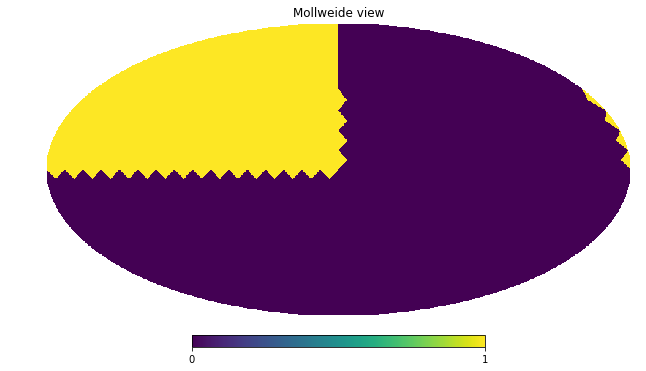

In [3]:
# The Chinchilla field of view: highlights all available pixels in yellow
# (I don't think the diamond edges are actually available)
mask = np.array([i in chinchilla_pixels for i in range(768)],dtype=int)
hp.mollview(mask,nest=True)

In [4]:
def getPixelsFromCenter(ra, dec, camera=None):
    '''
   Returns all pixels which overlap with the field of view of the
   camera pointed at position (ra, dec) on the sky

   Parameters
   ----------
   ra : float
     The RA value of the boresight of the camera
   dec : float
     The Dec value of the boresight of the camera
   camera : lsst.afw.geom.camera.Camera, optional
     camera object used as template
     
   Returns
   -------
   ipix : array
     The pixels which cover the field of view.

    '''
    if camera is None:
        camera = camMapper._makeCamera()
    
    boresight = geom.SpherePoint(ra, dec, geom.degrees)
    corners = [
        getWcsFromDetector(camera['R41_S20'], boresight).pixelToSky(0,4071),
        getWcsFromDetector(camera['R43_S22'], boresight).pixelToSky(3999,4071),
        getWcsFromDetector(camera['R34_S22'], boresight).pixelToSky(3999,4071),
        getWcsFromDetector(camera['R14_S02'], boresight).pixelToSky(3999,0),
        getWcsFromDetector(camera['R03_S02'], boresight).pixelToSky(3999,0),
        getWcsFromDetector(camera['R01_S00'], boresight).pixelToSky(0,0),
        getWcsFromDetector(camera['R10_S00'], boresight).pixelToSky(0,0),
        getWcsFromDetector(camera['R30_S20'], boresight).pixelToSky(0,4071)
    ]
    cornerRAList = np.array([corner.getRa().asDegrees() for corner in corners])
    cornerDecList = np.array([corner.getDec().asDegrees() for corner in corners])
    vecList = hp.ang2vec(cornerRAList,cornerDecList,lonlat=True)
    return hp.query_polygon(8,vecList,inclusive=True,nest=True, fact = 128)

# Get Pointing Positions
We need to get a list of (ra, dec) values for our tiling that 1) cover as much of the sky as possible and 2) do not overlap.
## Strategy: 
1. start at bottom.
2. go to center. go right. go back to center. go left. move up. 
3. repeat step 2 until at top.

In [5]:
import lsst.afw.geom as geom

In [6]:
# Start at bottom
pointingList = []
currLat = 2

while(currLat < 89):
    # Go to center
    currLon = 90
    midPoint = geom.SpherePoint(currLon, currLat, geom.degrees)
    pointingList.append(midPoint)
    
    # Go right
    while(currLon < 180 - 2/np.cos(currLat*np.pi/180)):
        point = geom.SpherePoint(currLon, currLat, geom.degrees)
        if point.separation(pointingList[-1]).asDegrees() < 4:
            currLon += 0.2/np.cos(currLat*np.pi/180)
            continue
        pointingList.append(point)
        currLon += 4/np.cos(currLat*np.pi/180)
    
    # Go back to center
    currLon = 90 - 4/np.cos(currLat*np.pi/180)
    while(midPoint.separation(geom.SpherePoint(currLon, currLat, geom.degrees)).asDegrees() < 4):
        currLon -= 0.2/np.cos(currLat*np.pi/180)
    
    # Go left
    while(currLon > 2/np.cos(currLat*np.pi/180)):
        point = geom.SpherePoint(currLon, currLat, geom.degrees)
        if point.separation(pointingList[-1]).asDegrees() < 4:
            currLon -= 0.2/np.cos(currLat*np.pi/180)
            continue
        pointingList.append(point)
        currLon -= 4/np.cos(currLat*np.pi/180)
    
    # Move up and repeat
    currLat += 4

### Check that these points are valid

In [7]:
from lsst.obs.lsst import LsstCamMapper as camMapper
from lsst.obs.lsst.lsstCamMapper import getWcsFromDetector

In [8]:
# Check for points that might overlap with the boundary and remove them (there are 2)
toRemove = []
for point in pointingList:
    for lat in np.arange(0,90,0.1):
        if point.separation(geom.SpherePoint(0,lat,geom.degrees)).asDegrees() < 2.2:
            print(point, (0,lat))
            toRemove.append(point)
            break
        if point.separation(geom.SpherePoint(180,lat,geom.degrees)).asDegrees() < 2.2:
            print(point, (180,lat))
            toRemove.append(point)
            break
for point in toRemove:
    pointingList.remove(point)

(150.209466, +86.000000) (180, 85.60000000000001)
(29.790534, +86.000000) (0, 85.60000000000001)


In [9]:
# Check for points that overlap with each other (there are none)
for i in range(len(pointingList)):
    for j in range(i):
        if pointingList[j].separation(pointingList[i]).asDegrees() < 3.99:
            print(i, j, pointingList[j].separation(pointingList[i]).asDegrees())

In [10]:
# Check for points that require chinchilla pixels that do not exist (there are none)
camera = camMapper._makeCamera()
for point in pointingList:
    for pixel in getPixelsFromCenter(point.getRa().asDegrees(), point.getDec().asDegrees(), camera):
        if pixel not in chinchilla_pixels:
            print(point, pixel)

In [11]:
# we have approximately 5700 square degrees of coverage
print(len(pointingList))

590


# Test the tiling on a boresight that overlaps three HEALpix pixels

In [12]:
from astropy.io import fits

In [13]:
boresight = pointingList[0]
pixels = getPixelsFromCenter(boresight.getRa().asDegrees(), boresight.getDec().asDegrees(), camera)
wcsList = {detector : getWcsFromDetector(detector, boresight) for detector in camera}

In [14]:
testFiles = [os.path.join(root,fNamePattern.format(pixel)) for pixel in pixels]
hdulists = [fits.open(file) for file in testFiles]
data = [hdulist[1].data for hdulist in hdulists]
dummy = fits.open(os.path.join(root,fNamePattern.format(0)))

In [15]:
def skyToCamPixel(ra, dec):
    loc = geom.SpherePoint(ra, dec, geom.degrees)
    distance = loc.separation(boresight)
    if distance.asDegrees() > 2.2:
        return 'OOB', 0, 0
    for det in wcsList:
        pix = geom.Point2I(wcsList[det].skyToPixel(loc))
        if det.getBBox().contains(pix):
            return det.getName(), pix.getX(), pix.getY()
    return 'OOB', 0, 0

In [16]:
skyToCamPixel = np.vectorize(skyToCamPixel, otypes=(str, int, int))

In [17]:
def inBoundsFast(ra, dec):
    loc = geom.SpherePoint(ra, dec, geom.degrees)
    distance = loc.separation(boresight)
    if distance.asDegrees() > 2.2:
        return False
    for det in wcsList:
        pix = geom.Point2I(wcsList[det].skyToPixel(loc))
        if det.getBBox().contains(pix):
            return True
    return False

inBoundsFast = np.vectorize(inBoundsFast)

In [18]:
endOfLast = 0
for i, hdu in enumerate(data):
    ra = hdu['RA'][:10000]
    dec = hdu['DEC'][:10000]
    valid = hdu[:10000][inBoundsFast(ra, dec)]
    dummy[1].data[endOfLast:endOfLast+len(valid)] = valid
    endOfLast = len(valid)
dummy[1].data = dummy[1].data[:endOfLast]

In [19]:
dummy[1].data['TRA'] = boresight.getRa().asDegrees()
dummy[1].data['TDEC'] = boresight.getDec().asDegrees()

In [20]:
print(dummy[1].data['TRA'])
print(dummy[1].data['TDEC'])

[90. 90. 90. ... 90. 90. 90.]
[2. 2. 2. ... 2. 2. 2.]


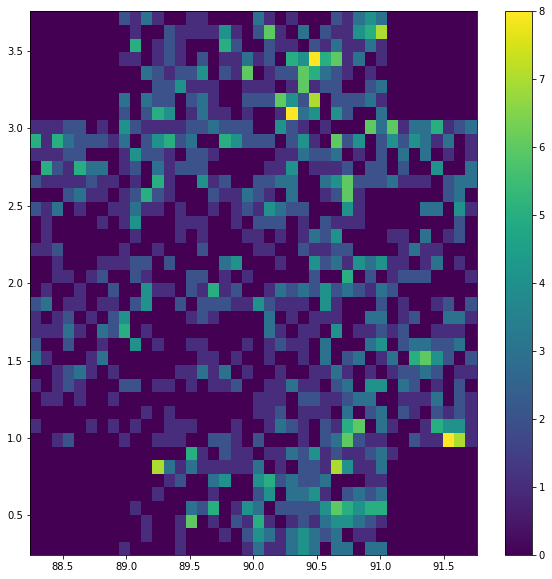

In [21]:
rat = dummy[1].data['RA']
dect = dummy[1].data['DEC']
f = plt.figure(figsize=(10,10))
plt.hist2d(rat, dect, bins=(40,40))
plt.colorbar()
plt.show()

In [23]:
dummy.writeto('outputs/samplefits0.fits')

In [26]:
ayy = set()
for point in pointingList:
    ayy.update(getPixelsFromCenter(point.getRa().asDegrees(), point.getDec().asDegrees(), camera))
print(set(chinchilla_pixels).issubset(ayy))
print(ayy.issubset(chinchilla_pixels))

True
True
